# 1. Data understanding and preparation

The aim of this part is to extract some important features from the table `Laboratory_events`, in order to build insights for the patient profile. 
This notebook is divided in two parts: 
<ul>
    <li><b>Data understanding</b></li>
    <li><b>Data Preparation</b></li>
</ul>

Before diving into the further steps, ensure to have installed the data analitycs libraries: 

In [2]:
%conda install pandas scipy seaborn 

2 channel Terms of Service accepted
Channels:
 - defaults
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 25.9.1
    latest version: 25.11.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


## 1.1 Data understanding

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

notebook_dir = Path().resolve()
data_path = notebook_dir.parents[1] / "Data" / "procedure_code_4.csv"
df = pd.read_csv(data_path)

In [4]:
df.shape

(14497, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14497 entries, 0 to 14496
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   subject_id  14497 non-null  int64 
 1   hadm_id     14497 non-null  int64 
 2   seq_num     14497 non-null  int64 
 3   chartdate   14497 non-null  object
 4   icd_code    14497 non-null  object
 5   long_title  14497 non-null  object
dtypes: int64(3), object(3)
memory usage: 679.7+ KB


## 1.2 Data cleaning
We estimate the percentage of *missing values* contained in each column. 

In [6]:
for col in df.columns:
    missing_count = df[col].isnull().sum()
    missing_percentage = (missing_count / len(df)) * 100
    print(f"Column '{col}': {missing_percentage:.2f}% missing values")

Column 'subject_id': 0.00% missing values
Column 'hadm_id': 0.00% missing values
Column 'seq_num': 0.00% missing values
Column 'chartdate': 0.00% missing values
Column 'icd_code': 0.00% missing values
Column 'long_title': 0.00% missing values


Now, we estimate the types hiddenly taken by each columns

In [7]:
for col in df.columns:
    print (f"{col}: {df[col].map(type).value_counts()}")

subject_id: subject_id
<class 'int'>    14497
Name: count, dtype: int64
hadm_id: hadm_id
<class 'int'>    14497
Name: count, dtype: int64
seq_num: seq_num
<class 'int'>    14497
Name: count, dtype: int64
chartdate: chartdate
<class 'str'>    14497
Name: count, dtype: int64
icd_code: icd_code
<class 'str'>    14497
Name: count, dtype: int64
long_title: long_title
<class 'str'>    14497
Name: count, dtype: int64


We have no missing values on this dataFrame.


## 1.3 Data Preparation

Check if we have duplicated records

In [8]:
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(14497, 6)
(14497, 6)


### 1.3.1 Standardization

In [9]:
df['chartdate'] = pd.to_datetime(df['chartdate'])

In [10]:
string_cols = df.select_dtypes(include=['object']).columns
for col in string_cols:
    df[col] = df[col].str.strip()   
    df[col] = df[col].astype('string')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14497 entries, 0 to 14496
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   subject_id  14497 non-null  int64         
 1   hadm_id     14497 non-null  int64         
 2   seq_num     14497 non-null  int64         
 3   chartdate   14497 non-null  datetime64[ns]
 4   icd_code    14497 non-null  string        
 5   long_title  14497 non-null  string        
dtypes: datetime64[ns](1), int64(3), string(2)
memory usage: 679.7 KB


Now the records are standardized

### 1.3.2 Data distributions

<Axes: xlabel='icd_code', ylabel='count'>

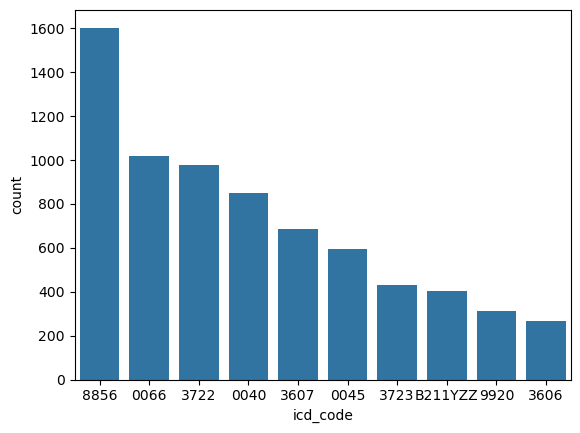

In [12]:
import seaborn as sns

icd_codes = df['icd_code'].value_counts().reset_index()
sns.barplot(data=icd_codes.head(10),
            x='icd_code',
            y='count', 
            )

### 1.3.3 Feature extraction

In [16]:
# hadm_id aggregation: total count of procedures and procedure variety
proc_features = (
    df
    .groupby('hadm_id')
    .agg(
        total_procedures=('icd_code', 'size'),          # count
        unique_procedures=('icd_code', 'nunique'), # variety
        n_days_span=('chartdate', lambda x: (x.max() - x.min()).days)  # time span
    )
    .reset_index()
)

print(f"Feature summary:\n{proc_features.describe()}")
proc_features.head(10)

Feature summary:
            hadm_id  total_procedures  unique_procedures  n_days_span
count  3.459000e+03       3459.000000        3459.000000  3459.000000
mean   2.502943e+07          4.191096           4.058398     1.442324
std    2.853466e+06          2.989024           2.717689     3.541510
min    2.000790e+07          1.000000           1.000000     0.000000
25%    2.264270e+07          2.000000           2.000000     0.000000
50%    2.506423e+07          3.000000           3.000000     0.000000
75%    2.747180e+07          6.000000           6.000000     1.000000
max    2.999967e+07         28.000000          21.000000    43.000000


,hadm_id,total_procedures,unique_procedures,n_days_span
0,20007905,5,5,1
1,20014999,3,3,0
2,20015927,2,2,0
3,20021932,7,7,0
4,20022560,5,5,0
5,20026345,11,11,7
6,20029195,8,7,0
7,20029361,3,3,2
8,20034781,8,8,1
9,20034792,5,5,1


In [17]:
proc_features.to_csv(notebook_dir.parents[1] / "Custom" / "procedure_code_summary.csv", index=False)